In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage as scp

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
def makeCircle(size, center, r=10):
    x=center[0]
    y=center[1]
    arr = np.zeros([size,size])
    for i in range(-r,r):
        for j in range(-r,r):
            dist=np.sqrt(i**2+j**2)
            if dist<r:
                if i+y>0 and i+y<size:
                    if j+x>0 and j+x<size:
                        arr[y+i,x+j] = 1
    return arr
"""
x=400
y=400
plt.imshow(makeCircle(size=400,r=10,center=[x,y]), interpolation='none',cmap="gray",vmin=0,vmax=1)
plt.show()
plt.imshow(makeGaussian(size=400,fwhm=10,center=[x,y]), interpolation='none',cmap="gray",vmin=0,vmax=1)
plt.show()
"""

'\nx=400\ny=400\nplt.imshow(makeCircle(size=400,r=10,center=[x,y]), interpolation=\'none\',cmap="gray",vmin=0,vmax=1)\nplt.show()\nplt.imshow(makeGaussian(size=400,fwhm=10,center=[x,y]), interpolation=\'none\',cmap="gray",vmin=0,vmax=1)\nplt.show()\n'

In [2]:
def generate_background(x_dim, y_dim):
    my_dpi = 100
    arr = np.zeros((x_dim,y_dim))
    for i in range(20000):
        x=random.randint(0-10,x_dim+10)
        y=random.randint(0-10,x_dim+10)
        
        fwhm=10
        arr=arr+makeGaussian(x_dim,fwhm=fwhm,center=[x,y])
    arr = np.abs(arr - np.min(arr))/np.max(arr)
    
    #arr = np.where(arr<0.1,arr+random.random()*1/arr,arr)
    #print(arr)
    return arr



In [11]:
from scipy import interpolate
def generate_signal(arr,points_x=None,points_y=None,nr_lines=4,length=100,d_theta=0.5,signal_attenuation=2, pos_factor=1.2):
    arr_pos = np.zeros_like(arr)
    arr_neg = np.zeros_like(arr)
    signal_mask = np.zeros_like(arr)
    x_dim, y_dim = arr.shape

    if points_x==None and points_y==None:
        length=length + random.randint(-int(length/2),int(length/2))
        theta = random.random()*2*np.pi
        #d_theta=0.5
        start_x = random.randint(50,x_dim-50)
        start_y = random.randint(50,y_dim-50)
        x=np.array([])
        y=np.array([])
        for i in range(nr_lines):
            theta=theta+(random.random()-0.5)*2*d_theta
            end_x = start_x + np.cos(theta)*length
            end_y = start_y + np.sin(theta)*length
            f = interpolate.interp1d([start_x,end_x], [start_y,end_y],kind="slinear")
            xnew = np.linspace(start_x, end_x, 2*length)
            ynew = f(xnew)
            x=np.append(x,xnew)
            y=np.append(y,ynew)
            start_x=end_x
            start_y=end_y


    for x1,y1 in zip(x,y):
        y_n = int(y1+random.randint(-3,3))
        x_n = int(x1+random.randint(-3,3))
        arr_pos = arr_pos + makeGaussian(x_dim,fwhm=9,center=[x_n,y_n])
        arr_neg = arr_neg - makeGaussian(x_dim,fwhm=10,center=[x_n,y_n])
        signal_mask = signal_mask + makeCircle(x_dim,r=4,center=[x_n,y_n])
        #arr_s=arr_s+1.2*makeGaussian(x_dim,fwhm=9,center=[x_n,y_n])-makeGaussian(x_dim,fwhm=10,center=[x_n,y_n])
    arr_sum = pos_factor * arr_pos + arr_neg
    arr_sum = arr_sum/(signal_attenuation * np.max(arr_sum))
    #arr_pos = pos_factor * arr_pos/(np.max(arr_pos))
    return arr_sum , signal_mask





In [ ]:
from scipy import interpolate
def generate_signal_junk(arr,points_x=None,points_y=None,nr_points=4):
    arr_s = np.zeros_like(arr)
    x_dim, y_dim = arr.shape
    if points_x==None and points_y==None:
        signal_length=random.randint(150,300)
        start_x = random.randint(0,x_dim-signal_length)
        start_y = random.randint(0,y_dim-signal_length)
        points_x = np.unique(np.random.randint(start_x, start_x+signal_length,size=nr_points), axis=0)
        #points_x = np.sort(points_x)
        #points_y = np.unique(np.random.randint(start_y, start_y+signal_length,size=nr_points), axis=0)
        points_y = np.random.randint(start_y, start_y+signal_length,size=len(points_x))
        points_y = np.sort(points_y)
    f = interpolate.interp1d(points_x, points_y,kind="slinear")
    xnew = np.arange(points_x[0], points_x[-1], 1)
    ynew = f(xnew)

    for x,y in zip(xnew,ynew):
        y_n = int(y+random.randint(-4,4))
        x_n = int(x+random.randint(-4,4))
        
        arr_s=arr_s+makeGaussian(x_dim,fwhm=10,center=[x_n,y_n])
    arr_s = np.abs(arr_s - np.min(arr_s))/np.max(arr_s)
    return arr_s



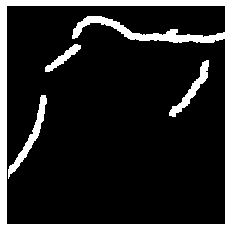

In [14]:

for i in range(120,180):
    arr=generate_background(400,400)
    signal=np.zeros_like(arr)
    signal_mask=np.zeros_like(arr)
    nr_signals = random.randint(2,8) # nr of seperate lines to be spawned
    for j in range(nr_signals):
        nr_lines = random.randint(5,15) # nr of line segments
        length = random.randint(10,50) # length of segments
        d_theta = random.random() # size of the random angle multiple
        signal_attenuation = 1 + random.random()*2 # How much to dampen the signal
        pos_factor = 1.2 # The ratio between positive signal vs. negative

        signal_tmp, signal_mask_tmp = generate_signal(arr=arr,
                                                    nr_lines=nr_lines,
                                                    length=length,
                                                    d_theta=d_theta,
                                                    signal_attenuation=signal_attenuation,
                                                    pos_factor=pos_factor)
        signal = signal + signal_tmp
        signal_mask = signal_mask + signal_mask_tmp
    arr =arr + signal
    arr = scp.gaussian_filter(arr,2)
    signal_mask = np.where(signal_mask>0,1,0)
    #plt.subplot(1,2,1)
    plt.imshow(arr, interpolation='none',cmap="gray",vmin=-0.4,vmax=1.5)
    plt.axis('off')
    plt.savefig("simulated_data/"+str(i)+".png", bbox_inches='tight')
    #plt.show()
    #plt.subplot(1,2,2)
    plt.imshow(signal_mask, interpolation='none',cmap="gray",vmin=0,vmax=1)
    plt.axis('off')
    plt.savefig("simulated_data/"+str(i)+"_target.png", bbox_inches='tight')
    #plt.show()

